# Lecture 19: Softmax regression, multiclass classifier

In the last lecture we have learned the logistic regression to classify "0" digit or a "1" digit based on pixel intensities on a 28x28 grid.

Today we will learn how to classify all 10 digits.

Reference: adapted from the MATLAB tutorial in [Stanford Deep Learning tutorial](http://deeplearning.stanford.edu/tutorial/).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST
Let us load the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/), both testing and training data. You can download the `npz` format file on Canvas file tab.

## What does the data look like?
* (If you use the same routine with Lecture 18 to load the `csv` data) The first column of `data_train[:,0]` and `data_test[:,0]` are the labels, and the rest 784 columns `data_train[:,1:]` and `data_test[:,1:]`represent a 28x28 grayscale image. 
* If you have loaded the `npz` data (numpy native format), `X_train` and `X_test` both have 784 columns which represent a 28x28 grayscale image. `y_train` and `y_test`, which range from 0 to 9 total 10 classes, are the labels of the training samples, respectively.

In [7]:
data_train = np.load('mnist_train.npz')
X_train = data_train['X']
y_train = data_train['y']

In [8]:
type(data_train)

numpy.lib.npyio.NpzFile

In [9]:
data_train.files

['X', 'y']

In [11]:
X_train.shape
# 784 = 28 x 28

(60000, 784)

In [12]:
y_train.shape

(60000,)

In [14]:
y_train[:3]

array([5., 0., 4.])

In [15]:
data_test = np.load('mnist_test.npz')
X_test = data_test['X']
y_test = data_test['y']

In [48]:
X_train[1,:].shape

(784,)

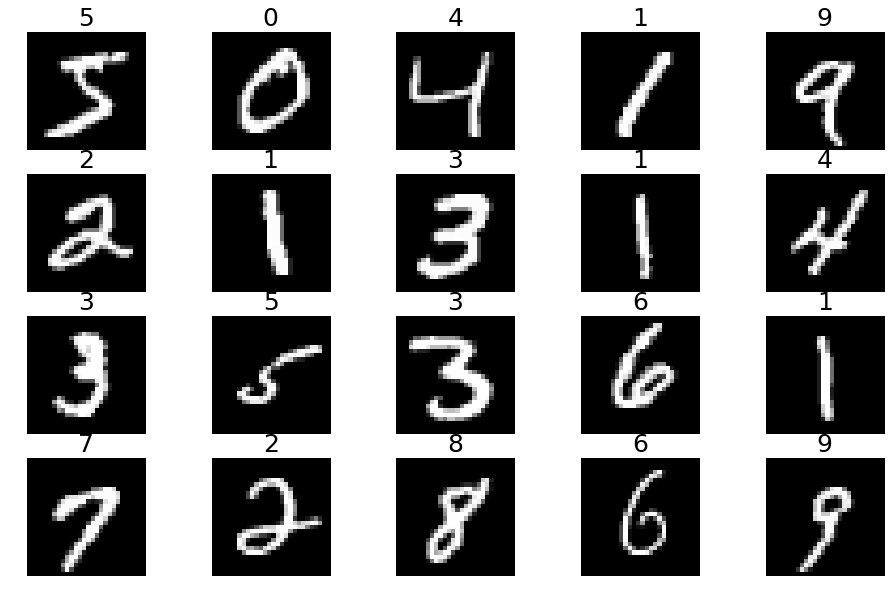

In [50]:
# visualize the first 20 rows of the training data, with their labels.
_, axes = plt.subplots(4,5, figsize=(16, 10))

axes = axes.reshape(-1)

for i in range(20):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(X_train[i,:].reshape(28,28), cmap = 'gray')
    axes[i].set_title(str(int(y_train[i])), color= 'black', fontsize=25)
plt.show()

# Softmax regression (reading)
<br>
Softmax regression (or multinomial logistic regression) is a generalization of logistic regression to the case where we want to handle multiple classes. In logistic regression we assumed that the labels were binary: $y^{(i)}∈{0,1}$. In the last lecture, we have used such a classifier to distinguish between two kinds of handwritten digits. Softmax regression allows us to handle $y^{(i)}\in \{1,\dots, K\}$ where $K$ is the number of classes.

Given a test input $\mathbf{x}\in \mathbb{R}^n$ (a 28x28 image flattened to a `(784,)` array), we want to estimate the probability that $P(y=k|\mathbf{x})$ for each value of $k=1,\dots,K$. In other words, from the input image, we want to estimate the probability of this image being classified as each label among $K$ labels, and we choose the highest probable one to label this image. Thus, our model (hypothesis) will output a $K$-dimensional vector (whose elements sum to $1$ to make it a probability) giving us our $K$ estimated probabilities. Concretely, our model $h(\mathbf{x}; \mathbf{w})$, which stands for given the current weights $\mathbf{w}$ the probability vector for $\mathbf{x}$, takes the form:

$$
h_{\mathbf{w}}(\mathbf{x}) =
\begin{pmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w}) \\
P(y = 2 | \mathbf{x}; \mathbf{w}) \\
\vdots \\
P(y = K | \mathbf{x}; \mathbf{w})
\end{pmatrix}
=
\frac{1}{ \sum_{j=1}^{K}{\exp\big(\mathbf{w}_j^{\top} \mathbf{x}\big) }}
\begin{pmatrix}
\exp(\mathbf{w}_1^{\top} \mathbf{x} ) \\
\exp(\mathbf{w}_2^{\top} \mathbf{x} ) \\
\vdots \\
\exp(\mathbf{w}_K^{\top} \mathbf{x} ) \\
\end{pmatrix}.
$$
Totally we have $K$ sets of parameters, $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K$, and the factor $\sum_{j=1}^{K}{\exp\big(\mathbf{w}_j^{\top} \mathbf{x}\big)}$ normalizes the results to be a probability.

When we implement the softmax regression, it is usually convenient to represent $\mathbf{w}$ containing all $K$ sets of parameters as a $n\times K$ matrix obtained by concatenating $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K$ into columns, so that $\mathbf{w}_k = (w_{k1}, \dots, w_{kn})^{\top} = (w_{kl})$ for $l = 1,\dots, n$

$$
\mathbf{w} = \left(
\begin{array}{cccc}| & | & | & | \\
\mathbf{w}_1 & \mathbf{w}_2 & \cdots & \mathbf{w}_K \\
| & | & | & |
\end{array}\right),
$$
and $\mathbf{w}^{\top}\mathbf{x}$ would be sensible and vectorized to be computed.



# Loss function
Before introducting the loss the function for the softmax regression, we define the following indicator function:
$$
1_{\{y = k\}} = 1_{\{k\}}(y) = \delta_{yk} = \begin{cases}
1 & \text{when } y = k,
\\[5pt]
0 & \text{otherwise}.
\end{cases}
$$
First let us recall the loss function for the logistic regression, and we rewrite it as: we have $N$ training samples $(\mathbf{x}^{(i)}, y^{(i)})$
$$
\begin{aligned}
\ell^{\text{Logistic}} (\mathbf{w}) &= - \sum_{i=1}^N 
\Bigl\{y^{(i)} \ln\big( h(\mathbf{x}^{(i)}) \big) 
+ (1 - y^{(i)}) \ln\big( 1 - h(\mathbf{x}^{(i)}) \big) \Bigr\}
\\
& = - \sum_{i=1}^N \sum_{k=0}^1
\Bigl\{ 1_{\{y^{(i)} = k\}} \ln P\big(y^{(i)}=k | \mathbf{x}^{(i)} ; \mathbf{w} \big) \Bigr\}.
\end{aligned}
$$

Now our loss function for the softmax regression is then the generalization of above:

$$
\begin{aligned}
L (\mathbf{w}) = L^{\text{Softmax}} (\mathbf{w}) & = - \sum_{i=1}^N \sum_{k=1}^K
\Bigl\{ 1_{\{y^{(i)} = k\}} \ln P\big(y^{(i)}=k | \mathbf{x}^{(i)} ; \mathbf{w} \big) \Bigr\}
\\
 & = - \sum_{i=1}^N \sum_{k=1}^K
\left\{1_{\{y^{(i)} = k\}} \ln \Bigg( \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})}{\sum_{j=1}^{K} 
\exp\big(\mathbf{w}_j^{\top} \mathbf{x}^{(i)} \big) }  \Bigg)\right\}.
\end{aligned}
$$
Notice for every term in the sum w.r.t. to the labels, $\sum_{k=1}^K$, $1_{\{y^{(i)} = k\}} = 1$ for only one term among $K$ terms, and the rest is 0.

# Gradient of softmax loss function 
# (you might want to  re-derive this on paper)

Notice our weights to be trained have $K$ sets $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_K$, and each of the $k$-th weights vector has $n$ components: $\mathbf{w}_k = (w_{k1}, \dots, w_{kl},\dots, w_{kn})^{\top}$. The first subscript is $1\leq k \leq K$ (label's index, we have this many set of weights), the second subscript is $1\leq l\leq n$ ($\mathbf{x}$'s feature index). 

The indices involved are pretty complicated, to simplify the notation a bit, denote the probability predicted by our model of the $i$-th training sample being in the $k$-th class as:

$$
\sigma_{k}^{(i)}:= P\big(y^{(i)}=k | \mathbf{x}^{(i)} ; \mathbf{w} \big) = 
\frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})} {\sum_{m=1}^{K} 
\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)} )}
$$
then 
$$
\frac{\partial L }{\partial w_{jl}}
= - \sum_{i=1}^N \sum_{k=1}^K 
\left\{ 1_{\{y^{(i)} = k\} } \frac{\partial}{\partial w_{jl}}\Big( \ln \sigma_{k}^{(i)}\Big)
\right\}
= - \sum_{i=1}^N \sum_{k=1}^K 
\left\{ 1_{\{y^{(i)} = k\} } \frac{1}{\sigma_{k}^{(i)}}\frac{\partial}{\partial w_{jl}} \sigma_{k}^{(i)}
\right\}.
\tag{$\star$}
$$

Now computing the partial derivative above:

$$
\begin{aligned}
\frac{\partial \sigma_{k}^{(i)}}{\partial w_{jl}} 
&= 
\frac{\partial }{\partial w_{jl}} \left( \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})} {\sum_{m=1}^{K} 
\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)} )}\right)
\\
&= \frac{1}{\sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)} )}
\frac{\partial }{\partial w_{jl}} \left(  \exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})\right)
- \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})}
{ \left(\sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)}) \right)^2}
\frac{\partial }{\partial w_{jl}} \left(  \sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)})  \right)
\\
&= \frac{1}{\sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)} )}
1_{\{j = k\}} \exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})
\frac{\partial }{\partial w_{jl}} \left( \mathbf{w}_k^{\top} \mathbf{x}^{(i)} \right)
- \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})}
{ \left(\sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)}) \right)^2}
\exp(\mathbf{w}_j^{\top} \mathbf{x}^{(i)})
\frac{\partial }{\partial w_{jl}} \left( \mathbf{w}_j^{\top} \mathbf{x}^{(i)} \right).
\end{aligned}
\tag{$\dagger$}
$$

By the property of the indicator function, we have:

$$
1_{\{j = k\}} \exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})
\frac{\partial }{\partial w_{jl}} \left( \mathbf{w}_k^{\top} \mathbf{x}^{(i)} \right)
= \begin{cases}
\exp(\mathbf{w}_j^{\top} \mathbf{x}^{(i)}) x_l^{(i)} & \text{if } j=k,
\\[3pt]
0 & \text{if }j\neq k.
\end{cases}
$$

Hence, $(\dagger)$ can be further written as:

$$
\begin{aligned}
\frac{\partial \sigma_{k}^{(i)}}{\partial w_{jl}}  
= \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x}^{(i)})}
{ \sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)}) }
\left(
1_{\{j = k\}} - 
 \frac{\exp(\mathbf{w}_j^{\top} \mathbf{x}^{(i)})}
{ \sum_{m=1}^{K}\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)}) }
\right) x^{(i)}_l
= \sigma_{k}^{(i)} \left(
1_{\{j = k\}} - \sigma_{j}^{(i)} \right) x^{(i)}_l.
\end{aligned}
$$

Now plugging this back to $(\star)$:

$$
\begin{aligned}
\frac{\partial L }{\partial w_{jl}}
&= - \sum_{i=1}^N \sum_{k=1}^K 
\left\{ 1_{\{y^{(i)} = k\} } 
\left(
1_{\{j = k\}} - \sigma_{j}^{(i)} \right) x^{(i)}_l
\right\}
\\
&=- \sum_{i=1}^N 
x^{(i)}_l\left\{ \sum_{k=1}^K  
1_{\{y^{(i)} = k\} } 1_{\{j = k\}} - 
\sum_{k=1}^K 1_{\{y^{(i)} = k\} } \sigma_{j}^{(i)}  
\right\}
\\
&=
- \sum_{i=1}^N 
x^{(i)}_l\left(   
1_{\{y^{(i)} = j\} } -  \sigma_{j}^{(i)}  
\right)
\\
& = 
- \sum_{i=1}^N 
x^{(i)}_l\Big(   
1_{\{y^{(i)} = j\} } -  P\big(y^{(i)}=j | \mathbf{x}^{(i)} ; \mathbf{w} \big)  
\Big).
\end{aligned}
$$

This is pretty simple, and it has a nice interpretation similar to the maximum likelihood function: the term in the parenthesis is the difference between the actual probability and the probability estimation in our model.

Now the derivative of $L$ with respect the whole $j$-th set of weights is then:

$$
\frac{\partial L }{\partial \mathbf{w}_{j}}
= - \sum_{i=1}^N 
\mathbf{x}^{(i)}\left(   1_{\{y^{(i)} = j\} } -  \sigma_{j}^{(i)}  
\right)
=
\sum_{i=1}^N 
\mathbf{x}^{(i)}\left(    \frac{\exp(\mathbf{w}_j^{\top} \mathbf{x}^{(i)})} {\sum_{m=1}^{K} 
\exp(\mathbf{w}_m^{\top} \mathbf{x}^{(i)} )} -1_{\{y^{(i)} = j\} } 
\right).
\tag{$\diamond$}
$$

# Gradient descent
Now let us implement the gradient descent based on $(\diamond)$ above, with code adapted from Lecture 18. One big challenge here is that the weights are now represented by a matrix.

In [17]:
# global training data
X = X_train
y = y_train
N = len(y) # number of training samples
n = np.shape(X)[1] # 784, which is number of pixels (number of features)
K = 10 # number of classes

In [18]:
n

784

In [20]:
np.random.seed(666)
w  = 1e-4*np.random.random(n*K) 
# w: a (7840, ) array a small, random initial guess
# 7840 = 784x10, 784 features, 10 classes
# during computation it will be resized to total 10 columns standing for 10 sets of weights

In [22]:
# weights for first two classes
w.reshape(n,K)[:,:2]

array([[7.00437122e-05, 8.44186643e-05],
       [2.00247539e-05, 7.44154169e-05],
       [2.32362992e-06, 7.27321154e-05],
       ...,
       [2.96672070e-05, 4.70666347e-05],
       [4.54639959e-05, 8.55445610e-07],
       [8.88722408e-05, 1.36122991e-05]])

In [24]:
# the following single line computes e^(weights dot product with samples) 
# for each set of weights (K sets of weights for K classes)
# and for each data samples
# s is of shape (60000, 10)
s = np.exp(np.matmul(X,w.reshape(n,K)))
s[:2]

array([[3.5548548 , 3.99514731, 4.05174346, 3.76647625, 4.03539205,
        3.74817156, 3.56257827, 4.01870986, 3.62638062, 4.23358375],
       [4.71179996, 4.8744543 , 4.64823956, 4.49079842, 4.86802489,
        4.65967716, 4.63921643, 4.86412303, 4.70220507, 5.01239012]])

In [26]:
# computes the sum along axis = 1, summing up all columns for each row
np.apply_along_axis(np.sum, axis=1, arr= s)[:2]

array([38.59303791, 47.47092896])

In [28]:
# each row is normalized by its sum so that we get a probability (each number between 0 and 1, summing up to 1)
prob = s / np.apply_along_axis(np.sum, axis=1, arr= s).reshape(-1,1)
prob[:2]

array([[0.0921113 , 0.1035199 , 0.10498638, 0.09759471, 0.10456269,
        0.09712041, 0.09231142, 0.10413044, 0.09396463, 0.10969812],
       [0.09925654, 0.10268293, 0.0979176 , 0.09460102, 0.1025475 ,
        0.09815854, 0.09772753, 0.1024653 , 0.09905441, 0.10558863]])

In [29]:
# model sigma(x; w) 
# w: 10 sets weights
# X: training samples, of shape 60000 row by 784
# output: (60000, 10), i-th row represent the probabilities of i-th sample
# in the k-th class (k-th column entry)
def sigma(w,X):
    w = w.reshape(n,K)
    s = np.exp(np.matmul(X,w))
    total = np.apply_along_axis(np.sum, axis=1, arr=s).reshape(-1,1)
    prob = s / total
    return prob

# loss function, modulo by N (size of training data)
# a vectorized implementation with a for loop with only 10 iterations
def loss(w,X,y):
    loss_components = np.zeros(N)
    for k in range(K):
        loss_components += np.log(sigma(w,X))[:,k] * (y == k)
    # above is a dimension (60000,) array
    return -np.mean(loss_components) # same with loss_components.sum()/N

def gradient_loss(w,X,y):
    gradient_for_each_weight_class = np.empty([n,K]) 
    # 10 columns, each column represent a graident
    for k in range(K):
        gradient_for_all_training_data_for_class_k = (sigma(w,X)[:,k] - (y==k)).reshape(-1,1)*X
        gradient_for_each_weight_class[:,k] = np.mean(gradient_for_all_training_data_for_class_k, axis=0)
    # we should return a (784,) array, which is averaging all 60000 training data
    return gradient_for_each_weight_class.reshape(n*K)

In [51]:
gradient_for_each_weight_class = np.empty([n,K]) # same shape with reshaped w
for k in range(10):
    gradient_for_all_training_data_for_class_k = (sigma(w,X)[:,k] - (y==k)).reshape(-1,1)*X
    gradient_for_each_weight_class[:,k] = np.mean(gradient_for_all_training_data_for_class_k, axis=0)

In [54]:
# label_residual is the (probability of sample x in class k predicted by our model) - (indicator function of x is in class k or not)
label_residual = (sigma(w,X)[:,k] - (y==k)).reshape(-1,1)
# label_residual*X is the key term in the gradient of softmax loss function
# gradient_for_kth_class_weight is the gradient of the weights responsible for the k-th class
gradient_for_kth_class_weight = np.mean(label_residual*X, axis = 0)
gradient_for_kth_class_weight.shape

(784,)

In [55]:
loss(w,X,y)

0.9814247301745523

In [56]:
np.linalg.norm(gradient_loss(w,X,y))

199.3463223447666

## Cross-validation function
For a fixed set of weights `sigma(w)` gives 10 probabilities for each sample (training or testing), here we want to implement a cross-validation function, takes input of `X_train` or `X_test`, compute the class label of the highest probability for each samples, and returns the accuracy.

In [33]:
# we define a cross validating function computing 
def cross_validate_acc(w,X,y):
    prob = sigma(w,X) # for each sample, it computes 10 probabilities based on current weight w
    highest_prob_index = np.argmax(prob, axis=1)
    return np.mean(highest_prob_index == y.astype(int))
    # same with (highest_prob_index == y.astype(int)).sum()/len(y)

In [30]:
prob = sigma(w,X)
prob[:3,:]

array([[0.0921113 , 0.1035199 , 0.10498638, 0.09759471, 0.10456269,
        0.09712041, 0.09231142, 0.10413044, 0.09396463, 0.10969812],
       [0.09925654, 0.10268293, 0.0979176 , 0.09460102, 0.1025475 ,
        0.09815854, 0.09772753, 0.1024653 , 0.09905441, 0.10558863],
       [0.09327886, 0.1024089 , 0.10386954, 0.09664264, 0.10512896,
        0.09983215, 0.10147139, 0.10390017, 0.09314344, 0.10032396]])

In [31]:
np.argmax(prob, axis=1)[:3]

array([9, 9, 4], dtype=int64)

In [34]:
eta = 1e-5  # step size (learning rate)
num_steps = 5

loss_at_eachstep = np.zeros(num_steps) # record the change of the loss function
for i in range(num_steps):
    loss_at_eachstep[i] = loss(w,X,y)
    dw = gradient_loss(w,X,y)
    w = w - eta * dw
    print("loss after", i+1, "iterations is: ", loss_at_eachstep[i])
    print("Training accuracy after", i+1, "iterations is: ", cross_validate_acc(w,X,y))
    print("Testing accuracy after", i+1, "iterations is: ", cross_validate_acc(w,X_test,y_test))
    # keep track of training accuracy just making sure we are in the right direction

loss after 1 iterations is:  1.7220303275646196
Training accuracy after 1 iterations is:  0.7476833333333334
Testing accuracy after 1 iterations is:  0.7578
loss after 2 iterations is:  1.3957194175114263
Training accuracy after 2 iterations is:  0.7187833333333333
Testing accuracy after 2 iterations is:  0.7268
loss after 3 iterations is:  1.2021446377303109
Training accuracy after 3 iterations is:  0.74845
Testing accuracy after 3 iterations is:  0.7547
loss after 4 iterations is:  1.1114388752685722
Training accuracy after 4 iterations is:  0.7353166666666666
Testing accuracy after 4 iterations is:  0.7411
loss after 5 iterations is:  1.0000586103254194
Training accuracy after 5 iterations is:  0.7632
Testing accuracy after 5 iterations is:  0.7721


# Slow, slow, slow
Because our dataset is big. One iteration of the gradient descent requires evaluating the gradient for all the training samples, and it takes takes $O(N\cdot d)$ cpu time ($N$: number of training samples, $d$:number of features in each sample). Stochastic gradient descent to remedy next time...

# Always scikit-learn to rescue

We can use `scikit-learn`'s [`LogisticRegression()` class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) in the `linear_model` to perform this task for us. Quoting the reference:
> In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the 'multi_class' option is set to 'ovr', and uses the cross- entropy loss if the 'multi_class' option is set to 'multinomial'. (Currently the 'multinomial' option is supported only by the 'lbfgs', 'sag' and 'newton-cg' solvers.)

> For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones.
For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs' handle multinomial loss; 'liblinear' is limited to one-versus-rest schemes.
'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas 'liblinear' and 'saga' handle L1 penalty.

In [62]:
# copy the example
from sklearn.linear_model import LogisticRegression
mnist_clf = LogisticRegression(random_state=666, 
                               solver='lbfgs', tol= 1e-5, max_iter = 2000, verbose=True, 
                               multi_class='multinomial')
# a faster solver is sag according to the reference
# verbose is printing output during training (only applies to lbfgs as solver)

In [63]:
mnist_clf.fit(X_train[:10000,:], y_train[:10000]) # we only use first 10000 images as training data

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:719: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=666, solver='lbfgs',
          tol=1e-05, verbose=True, warm_start=False)

In [64]:
mnist_clf.predict(X_test[:10, :])

array([7., 2., 1., 0., 4., 1., 4., 9., 6., 7.])

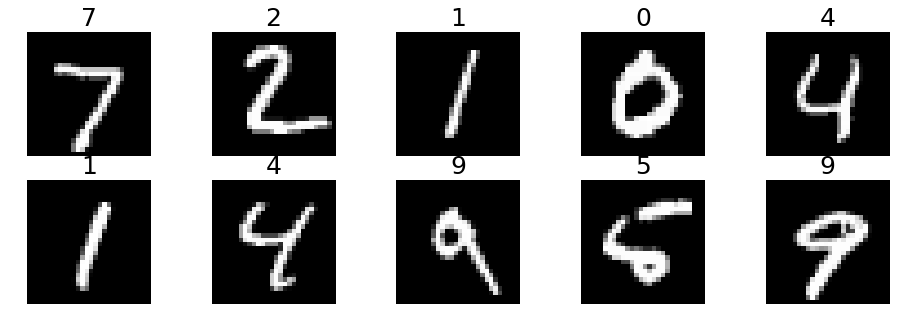

In [65]:
# we visualize the first 10 rows of X_test, see how the prediction goes
# visualize the first 20 rows of the training data, with their labels.
_, axes = plt.subplots(2,5, figsize=(16, 5))
axes = axes.reshape(-1)

for i in range(10):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(X_test[i,:].reshape(28,28), cmap = 'gray')
    axes[i].set_title(str(int(y_test[i])), color= 'black', fontsize=25)
plt.show()

## Result
Our softmax got 8 out 10 correct, not a bad score. Run the following cell will give you the prediction accuracy for the first 500 testing samples.

In [66]:
mnist_clf.score(X_test[:500,:], y_test[:500])

0.862